In [1]:
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn import metrics

from sklearn.model_selection import cross_val_score,  RepeatedStratifiedKFold, KFold, cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA


from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score,roc_auc_score


from sklearn.neural_network import MLPClassifier

default_seed = 1234

In [2]:

'''
Clinical annotation training data file.
'''

df_clinical_annotations = pd.read_csv("sc3_Training_ClinAnnotations.csv") 


'''
Gene expression values for each patient for some gene ids. 
'''

df_gene_expressions = pd.read_csv("MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv") 


In [3]:
df_clinical_annotations.shape

(583, 44)

In [4]:
'''
Pre-processing: Convert Entrez ids to string, to retain  consisteny with other columns while merging. 
'''

df_gene_expressions.rename(columns={"Unnamed: 0":"Entrez id"},inplace=True)
df_gene_expressions["Entrez id"] = df_gene_expressions["Entrez id"].astype("str") 
df_gene_expressions.set_index("Entrez id",inplace=True)

In [5]:

'''
Pre-processing: Remove gene records for which there is no information (zero rows) for all patients. 
'''

df_gene_expressions = df_gene_expressions.loc[~(df_gene_expressions==0.0).all(axis=1)]


In [6]:
df_gene_expressions

,MMRF_2490_1_BM,MMRF_2499_1_BM,MMRF_1089_1_BM,MMRF_1778_1_BM,MMRF_1777_1_BM,MMRF_1153_1_BM,MMRF_1392_1_BM,MMRF_1325_1_BM,MMRF_1846_1_BM,MMRF_1935_1_BM,...,MMRF_1847_1_BM,MMRF_1787_1_BM,MMRF_1048_1_BM,MMRF_2437_1_BM,MMRF_1242_5_BM,MMRF_1497_1_BM,MMRF_1380_2_BM,MMRF_1700_1_BM,MMRF_1918_1_BM,MMRF_1670_1_BM
Entrez id,,,,,,,,,,,,,,,,,,,,,
1,18.391400,15.189000,3.032370,0.584036,25.451500,5.321400,30.233400,20.331900,6.974960,15.087800,...,0.161310,26.763700,2.778470,7.703320,1.049320,17.505600,40.979600,34.538400,3.786580,7.078480
2,0.086096,13.214000,1.802760,0.052207,7.977120,0.872957,0.673016,0.976726,0.371472,0.636931,...,0.963704,0.341165,0.387432,3.741060,0.555109,2.001810,2.697300,1.041640,0.179793,45.022300
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010159,0.000000,0.000000,0.000000,...,0.032198,0.000000,0.000000,0.000000,0.000000,0.014439,0.003527,0.000000,0.000000,0.000000
9,3.063360,0.803676,0.399367,2.508220,1.135380,1.023830,0.574285,1.296310,1.525270,0.749036,...,2.664270,1.442940,3.198940,0.747902,3.307600,0.383040,1.782580,0.821487,2.228960,2.332800
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018875,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,47.576376,6.690800,9.615479,16.859950,9.671416,12.354488,25.037217,13.573754,10.211877,13.954144,...,18.301900,25.848136,12.641991,8.590391,21.785373,5.452901,23.806530,11.559909,20.697940,20.944770
9692,11.472770,1.150095,1.999532,2.330912,1.850304,4.621378,1.859862,1.682133,1.862996,1.418126,...,1.451266,2.977955,1.676421,1.764750,9.029644,0.531864,3.151712,2.637106,4.159455,2.493744
9720,1.256925,1.169509,1.350701,0.374735,2.086949,7.011621,48.960855,8.738658,0.251819,1.007040,...,34.204085,2.481888,1.646484,1.304965,1.271213,2.106967,0.380384,0.250397,12.378059,2.454738


In [7]:
'''
Pre-processing: The scales for gene expressions vary a lot. Hence, apply the min-max scaling. 
'''

df_gene_expressions = (df_gene_expressions.T-df_gene_expressions.T.min(axis=0))/(df_gene_expressions.T.max(axis=0)-df_gene_expressions.T.min(axis=0))

In [8]:
df_gene_expressions

Entrez id,1,2,3,9,10,13,14,15,16,18,...,84976,8509,86614,8778,8926,9570,9692,9720,9768,9797
MMRF_2490_1_BM,0.173322,0.001087,0.000000,0.378864,0.000000,0.0,0.612488,0.264458,0.522114,0.048921,...,0.586265,0.470146,0.000000,0.000548,0.409625,0.670131,0.492794,0.014686,0.502141,0.441693
MMRF_2499_1_BM,0.143143,0.166758,0.000000,0.090430,0.000000,0.0,0.065677,0.062207,0.120869,0.022650,...,0.080123,0.076300,0.000000,0.010589,0.216573,0.060988,0.034758,0.013662,0.019233,0.077012
MMRF_1089_1_BM,0.028577,0.022751,0.000000,0.038822,0.000000,0.0,0.072822,0.133982,0.110301,0.107994,...,0.159040,0.167935,0.117260,0.001859,0.134369,0.104562,0.072449,0.015784,0.124507,0.325609
MMRF_1778_1_BM,0.005504,0.000659,0.000000,0.308004,0.000000,0.0,0.318943,0.074858,0.480643,0.014878,...,0.395394,0.417417,0.000000,0.000504,0.233835,0.212495,0.087153,0.004353,0.023789,0.344959
MMRF_1777_1_BM,0.239857,0.100670,0.000000,0.132770,0.000000,0.0,0.053836,0.073569,0.118303,0.009608,...,0.026372,0.053406,0.000000,0.001009,0.116583,0.105395,0.065827,0.024407,0.016931,0.048695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMRF_1497_1_BM,0.164974,0.025262,0.062762,0.036738,0.000000,0.0,0.007093,0.054751,0.034190,0.026901,...,0.101453,0.207429,0.000000,0.000822,0.164822,0.042545,0.007326,0.024642,0.008293,0.081867
MMRF_1380_2_BM,0.386196,0.034039,0.015330,0.215381,0.000000,0.0,0.281754,0.058412,0.143050,0.032270,...,0.222342,0.389626,0.000000,0.006408,0.362915,0.315990,0.123573,0.004419,0.026414,0.553306
MMRF_1700_1_BM,0.325493,0.013145,0.000000,0.092703,0.027754,0.0,0.178656,0.129564,0.187236,0.091504,...,0.115021,0.198450,0.123258,0.000465,0.179429,0.133531,0.100739,0.002897,0.068115,0.302287
MMRF_1918_1_BM,0.035685,0.002269,0.000000,0.272358,0.000000,0.0,0.270217,0.057896,0.293737,0.119707,...,0.161449,0.236783,0.000000,0.000800,0.235545,0.269676,0.168289,0.144943,0.050920,0.259323


In [9]:
'''
Pre-processing: Remove the columns from "df_clinical_annotations" with no information.
'''

columns_to_be_dropped = []
for column in df_clinical_annotations.columns.tolist():
    if len(df_clinical_annotations[column].unique().tolist()) == 1:
        columns_to_be_dropped.append(column)

columns_to_be_dropped.extend(["WES_mutationFileMutect","WES_mutationFileStrelkaIndel","WES_mutationFileStrelkaSNV","RNASeq_geneLevelExpFileSamplId"])

df_clinical_annotations.drop(columns = columns_to_be_dropped,inplace=True)




In [10]:
'''
Exploration: Check the label distribution. We have a good number of CENSORED patients.
'''

df_clinical_annotations["HR_FLAG"].value_counts()

FALSE       261
CENSORED    191
TRUE        131
Name: HR_FLAG, dtype: int64

In [11]:
'''
Exploration: The D_ISS column contains nan values.
'''

print(df_clinical_annotations["D_ISS"].unique())
print("============")
print(pd.crosstab(df_clinical_annotations["D_ISS"], df_clinical_annotations["HR_FLAG"]))
print("============")

print(df_clinical_annotations["D_ISS"].isna().sum())
print("============")

'''
Pre-processing: Replace nan entries with 0's. 
'''

df_clinical_annotations.fillna(0,inplace=True)
print(pd.crosstab(df_clinical_annotations["D_ISS"], df_clinical_annotations["HR_FLAG"]))


[ 1.  2.  3. nan]
HR_FLAG  CENSORED  FALSE  TRUE
D_ISS                         
1.0            65    103    21
2.0            75     90    44
3.0            46     62    57
20
HR_FLAG  CENSORED  FALSE  TRUE
D_ISS                         
0.0             5      6     9
1.0            65    103    21
2.0            75     90    44
3.0            46     62    57


In [12]:
'''
Pre-processing: Convert days to months.
'''

df_clinical_annotations["D_OS"] /= 30.5
df_clinical_annotations["D_PFS"] /= 30.5


In [13]:
'''
Exploration: There are no high risk patients with D_OS or D_PFS values > 18, or low risk patients with values <18.
It seems that these labels completely determine the patient risk category, and all patients with CENSORED flag are high risk patients.
'''

df_clinical_annotations[(df_clinical_annotations["D_OS"] < 18.0)  | (df_clinical_annotations["D_PFS"] < 18.0)]["HR_FLAG"].value_counts()     



CENSORED    191
TRUE        131
Name: HR_FLAG, dtype: int64

In [14]:
def assign_label(HR_FLAG, D_OS, D_PFS):
    if HR_FLAG == "TRUE":
        return 1
    elif HR_FLAG == "FALSE":
        return 0
    elif HR_FLAG == "CENSORED":
        return (1 if ((D_OS < 18.0) or (D_PFS < 18.0)) else 0) ## Using the hint.

    
'''
Pre-processing: Map gender to 1 or 0.
'''
df_clinical_annotations["D_Gender"]=df_clinical_annotations['D_Gender'].map({'Male': 1, 'Female': 0}) 

'''
Pre-processing: Convert TRUE, FALSE, or CENSORED to 1 or 0. 
'''
df_clinical_annotations['HR_FLAG'] = df_clinical_annotations.apply(lambda row : assign_label(row['HR_FLAG'],
                     row['D_OS'], row['D_PFS']), axis = 1)


    



<AxesSubplot:>

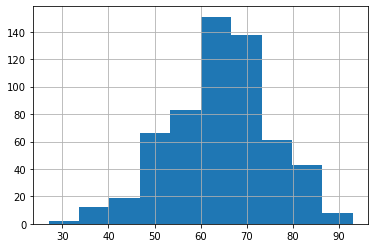

In [15]:
'''
Exploration: Age distribution.
'''

df_clinical_annotations["D_Age"].hist()

In [16]:
'''
Exploration: Cross-tabulation of age and HR_flag. 
'''
pd.crosstab(df_clinical_annotations["D_Age"], df_clinical_annotations["HR_FLAG"])

HR_FLAG,0,1
D_Age,,
27,1,0
31,1,0
36,1,2
37,2,1
38,0,1
39,1,1
40,2,1
41,1,0
42,2,0


In [17]:

'''
Exploration: Gender distribution.
'''

df_clinical_annotations["D_Gender"].value_counts() 

1    347
0    236
Name: D_Gender, dtype: int64

In [18]:
'''
Exploration: Cross-tabulation of gender and HR_flag. 
'''
pd.crosstab(df_clinical_annotations["D_Gender"], df_clinical_annotations["HR_FLAG"])

HR_FLAG,0,1
D_Gender,,
0,109,127
1,152,195


<AxesSubplot:>

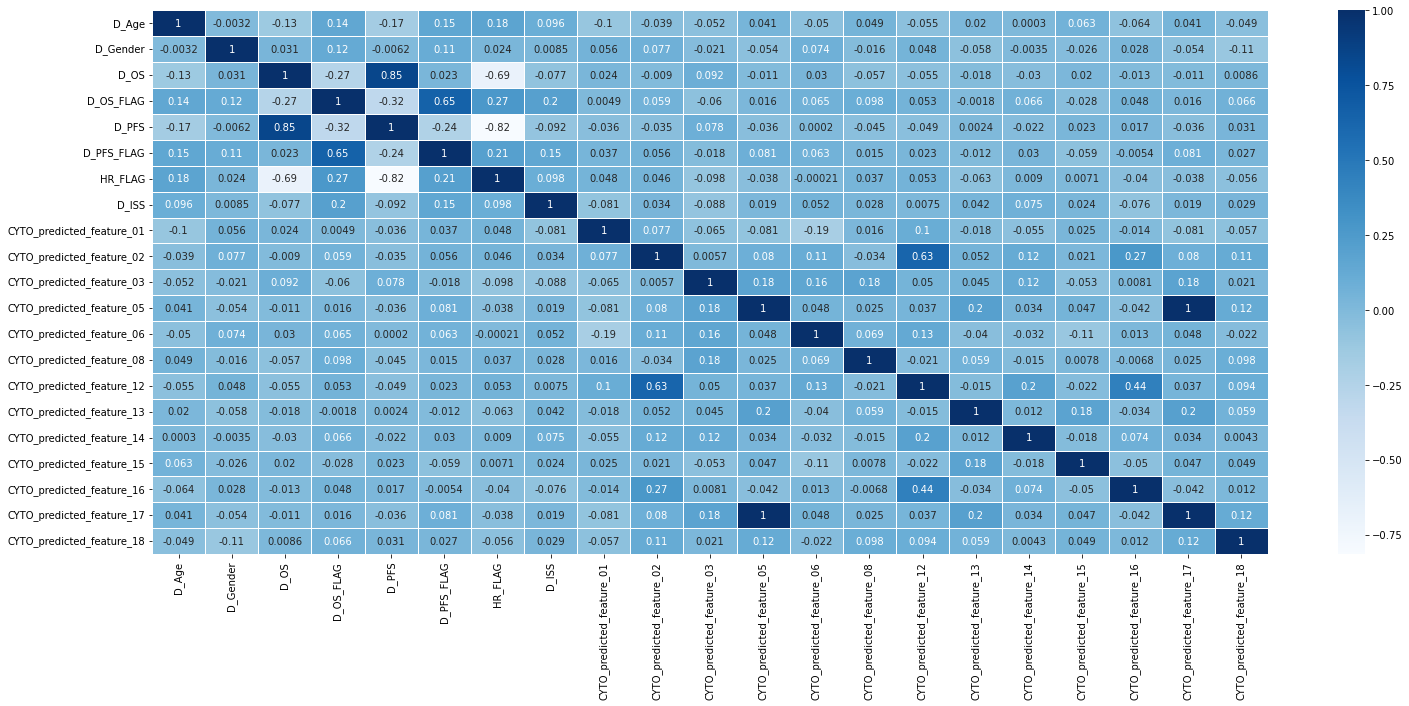

In [19]:
'''
Exploration: Basic correlation analysis.
'''

fig = plt.figure(figsize=(25, 10))
X = df_clinical_annotations.drop(columns=["RNASeq_transLevelExpFileSamplId","Patient","CYTO_predicted_feature_10"])

sns.heatmap(X.corr(),annot=True,linewidths=.5,cmap='Blues')



In [20]:
'''
Exploration and pre-processing: We observe high correlation between feature pairs (CYTO_predicted_feature_05, CYTO_predicted_feature_17) and
(CYTO_predicted_feature_02, CYTO_predicted_feature_12). We remove one feature from these pairs to reduce dimensionality. 

The features D_OS and D_PFS determine the HR_FLAG for CENSORED patients. We remove these features to avoid model leakage. 
'''

df_clinical_annotations.drop(columns=["CYTO_predicted_feature_10","CYTO_predicted_feature_05","CYTO_predicted_feature_02","Patient","D_PFS","D_OS"],inplace=True)


In [21]:
df_clinical_annotations_columns = df_clinical_annotations.columns.tolist()
df_clinical_annotations_columns.remove("RNASeq_transLevelExpFileSamplId")
df_clinical_annotations_columns.remove("HR_FLAG")

df_clinical_annotations_columns


['D_Age',
 'D_Gender',
 'D_OS_FLAG',
 'D_PFS_FLAG',
 'D_ISS',
 'CYTO_predicted_feature_01',
 'CYTO_predicted_feature_03',
 'CYTO_predicted_feature_06',
 'CYTO_predicted_feature_08',
 'CYTO_predicted_feature_12',
 'CYTO_predicted_feature_13',
 'CYTO_predicted_feature_14',
 'CYTO_predicted_feature_15',
 'CYTO_predicted_feature_16',
 'CYTO_predicted_feature_17',
 'CYTO_predicted_feature_18']

In [22]:
'''
Pre-processing: Join the df_clinical_annotations and df_gene_expressions. 
For each patient record, we now have gene expression columns. 
'''

df_merged = pd.merge(df_clinical_annotations, df_gene_expressions, left_on='RNASeq_transLevelExpFileSamplId',right_index=True)



In [23]:

target = "HR_FLAG"

'''
Pre-processing: Split  the merged dataframe into X and Y.
'''

Y = df_merged[target].to_numpy()
X = df_merged.drop(columns=["RNASeq_transLevelExpFileSamplId", "HR_FLAG"])


'''
Pre-processing: Bring the remaining columns in df_clinical_annotations_columns to the same scale.
'''

X[df_clinical_annotations_columns] = (X[df_clinical_annotations_columns] - X[df_clinical_annotations_columns].min())/(X[df_clinical_annotations_columns].max()-X[df_clinical_annotations_columns].min())



In [24]:
X.shape

(582, 23119)

In [25]:
isPCA = True
'''
Warning: Execution may take a while without PCA. 
'''
if isPCA:
    '''
    Pre-processing: Our reduced dimensionality should explain 90% of the variance in the original dataset.  
    '''
    
    X = PCA(n_components=0.9, random_state=default_seed,svd_solver = "full").fit_transform(X)


In [26]:
X.shape

(582, 266)

In [27]:

''' 
Processing:
Models
1) Logistic regression.
2) Ensamble decision tree with bagging.
3) Random forest
4) Multi-layer perceptron
5) Support vector machine
6) 5-nearest neighbor classification
'''
lr = LogisticRegression(C=0.1,
                        max_iter=1000,
                        n_jobs=-1,                       
                        random_state=default_seed,
                       )
bdt = BaggingClassifier(DecisionTreeClassifier(),
                        n_estimators=51,
                        n_jobs=-1,
                        random_state=default_seed                        
                       )

rf = RandomForestClassifier(n_estimators = 51,
                            n_jobs=-1,
                           random_state=default_seed
                           )

mlp = MLPClassifier(max_iter=1000,
                    activation="relu",
                   random_state=default_seed)


svm = SVC(C=5.1,
          kernel="rbf",
          gamma="auto",
          probability=True,
          random_state=default_seed)


nn = KNeighborsClassifier()

classifier_list = [
    (mlp, "Multi-layer Perceptron"),         
    (svm,"Support vector machine"),    
    (lr, "Logistic regression"),
    (bdt, "Bagging Decision tree"),
    (rf, "Random forest"),
    (nn, "Nearest neighbors")
    
]



Multi-layer Perceptron
Support vector machine
Logistic regression
Bagging Decision tree
Random forest
Nearest neighbors
                        fit_time  score_time  test_accuracy  test_precision  \
Classifier                                                                    
Multi-layer Perceptron     1.923       0.005          0.654           0.688   
Support vector machine     0.396       0.014          0.687           0.717   
Logistic regression        0.039       0.006          0.675           0.713   
Bagging Decision tree      3.310       0.044          0.579           0.595   
Random forest              0.397       0.024          0.581           0.589   
Nearest neighbors          0.003       0.035          0.533           0.588   

                        test_recall  test_f1_score  test_roc_auc_score  
Classifier                                                              
Multi-layer Perceptron        0.689          0.686               0.651  
Support vector machine      

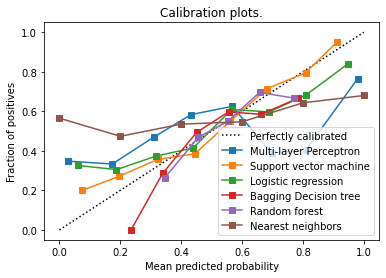

In [28]:

fig, ax = plt.subplots()


scoring = {
            'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' :    make_scorer(recall_score), 
           'f1_score' :  make_scorer(f1_score),
           "roc_auc_score":make_scorer(roc_auc_score)
            }

mean_scores = defaultdict(list)
std_scores = defaultdict(list)

'''
Processing: Stratification avoid label imbalance in training datasets.
'''
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=default_seed)

for i, (classifier, name) in enumerate(classifier_list):
    
    mean_scores["Classifier"].append(name)
    std_scores["Classifier"].append(name)
    print(name)
    '''
    Get model probabilities.
    '''
    prediction_probabilities = cross_val_predict(classifier, X, Y, cv=kfold, method='predict_proba',n_jobs=-1)
    
    '''
    Plot calibration curves.
    '''
    CalibrationDisplay.from_predictions(Y, prediction_probabilities[:,1],ax=ax,n_bins=8, name=name)
    
    
    '''
    10 fold cross-validation.
    '''
    results = cross_validate(estimator=classifier,X=X,y=Y, cv=kfold, scoring=scoring,n_jobs=-1)
    
    '''
    Using entire data as training data. 
    '''
    classifier.fit(X,Y)
    
    '''
    Save model.
    '''
    with open(name+".pkl", 'wb') as file:
        pickle.dump(classifier, file)
        
    '''
    Populate the metric dataframes.
    '''
    for metric in results:
        mean_scores[metric].append(results[metric].mean())
        std_scores[metric].append(results[metric].std())

    
mean_score_df = pd.DataFrame(mean_scores).set_index("Classifier")
std_score_df  = pd.DataFrame(std_scores).set_index("Classifier")


print(mean_score_df.round(3))    
ax.set_title("Calibration plots.")
if isPCA:
    plt.savefig("calibration_curves_with_PCA.pdf")
else:   
    plt.savefig("calibration_curves_without_PCA.pdf")

In [29]:
columns_tobe_printed = mean_score_df.columns.tolist()[2:]
mean_score_df[columns_tobe_printed].round(2).astype("str") +" +/- "+ std_score_df[columns_tobe_printed].round(2).astype("str")


,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score
Classifier,,,,,
Multi-layer Perceptron,0.65 +/- 0.07,0.69 +/- 0.06,0.69 +/- 0.09,0.69 +/- 0.06,0.65 +/- 0.07
Support vector machine,0.69 +/- 0.06,0.72 +/- 0.06,0.72 +/- 0.08,0.72 +/- 0.06,0.68 +/- 0.06
Logistic regression,0.68 +/- 0.05,0.71 +/- 0.06,0.7 +/- 0.06,0.71 +/- 0.04,0.67 +/- 0.06
Bagging Decision tree,0.58 +/- 0.05,0.6 +/- 0.03,0.74 +/- 0.07,0.66 +/- 0.04,0.56 +/- 0.05
Random forest,0.58 +/- 0.08,0.59 +/- 0.05,0.8 +/- 0.1,0.68 +/- 0.06,0.56 +/- 0.08
Nearest neighbors,0.53 +/- 0.05,0.59 +/- 0.06,0.51 +/- 0.06,0.55 +/- 0.06,0.54 +/- 0.05


In [30]:

from diffprivlib.models import LogisticRegression ### From Diffprivlib library. Importing it here to avoid naming conflict.

'''
Processing: Surprisingly, DP logistic regression's accuracy does not improve with epsilon and clipping threshold (C).
We do not pursue this direction for now.   

Each column in each dataframe below corresponds to an epsilon value.
'''

for C in np.arange(1.0,20,5):
    KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=default_seed)

    '''
    Processing: Clipping the L2 norm of each record to C.
    '''
    X_clipped = X* np.minimum(1.0,C/np.linalg.norm(X, axis=1)[:, np.newaxis])  

    accuracy_lr = defaultdict(list)
    for eps in np.linspace(0.1,10.0,10):    
        '''
        https://diffprivlib.readthedocs.io/en/latest/modules/models.html
        '''
        dp_classifier_lr = LogisticRegression(epsilon=eps, data_norm=C,n_jobs=-1)
        for train_index, test_index in KFold.split(X_clipped, Y):
            X_train, X_test = X_clipped[train_index], X_clipped[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            dp_classifier_lr.fit(X_train, y_train)
            accuracy_lr[eps].append(dp_classifier_lr.score(X_test, y_test))


    accuracy_lr = pd.DataFrame(accuracy_lr)
    print("=============================")
    print("C=",C)
    
    print(accuracy_lr)


C= 1.0
       0.1       1.2       2.3       3.4       4.5       5.6       6.7   \
0  0.444444  0.452991  0.470085  0.495726  0.495726  0.589744  0.504274   
1  0.470085  0.461538  0.521368  0.521368  0.521368  0.495726  0.435897   
2  0.474138  0.439655  0.431034  0.525862  0.577586  0.586207  0.577586   
3  0.525862  0.551724  0.534483  0.560345  0.500000  0.534483  0.594828   
4  0.474138  0.439655  0.508621  0.551724  0.508621  0.456897  0.543103   

       7.8       8.9       10.0  
0  0.555556  0.572650  0.521368  
1  0.623932  0.615385  0.555556  
2  0.491379  0.568966  0.612069  
3  0.543103  0.560345  0.568966  
4  0.465517  0.560345  0.543103  
C= 6.0
       0.1       1.2       2.3       3.4       4.5       5.6       6.7   \
0  0.555556  0.598291  0.487179  0.547009  0.452991  0.564103  0.376068   
1  0.393162  0.538462  0.521368  0.555556  0.487179  0.606838  0.495726   
2  0.474138  0.508621  0.551724  0.448276  0.586207  0.482759  0.586207   
3  0.456897  0.508621  0.517241